In [1]:
import os
import sys
print(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../'))

/home/ymz/src/pipelines/components/spider/pubmed


In [14]:
import os
import sys
from pubmed.parser.pubmed_xml_parser import PubmedXmlParser

focused_type = [
   'Randomized Controlled Trial', 
   'Clinical Trial',
   'Observational Study',
   'Controlled Clinical Trial',
   'Clinical Trial, Phase II',
   'Clinical Trial, Phase I',
   'Clinical Trial, Phase III',
   'Clinical Trial Protocol',
   'Clinical Study',
   'Randomized Controlled Trial, Veterinary',
   'Clinical Trial, Phase IV',
   'Pragmatic Clinical Trial',
   'Clinical Trial, Veterinary',
   'Equivalence Trial',
   'Adaptive Clinical Trial'
]

def _has_pmc_free_article(full_links):
   for full_link in full_links:
      if full_link['idType'] == 'pmc':
         return True
   return False

def _has_clinical_trial_link(databanks):
   for databanks in databanks:
      if databanks['databank_name'] == 'ClinicalTrials.gov':
         return True
   return False

def _is_clinical_trials_type(publication_types):
   for publication_type in publication_types:
      if publication_type.get('text', '') in focused_type:
         return True
   return False

def filter_clinical_trials_type(publication_types):
   result = []
   for publication_type in publication_types:
      if publication_type.get('text', '') in focused_type:
         result.append(publication_type)
   return result
def get_journal_year(article_journal):
   journal_year = article_journal.get('JournalIssue_PubDate_Year', "")
   if journal_year:
      return journal_year
   else:
      medlinedate =  article_journal.get('JournalIssue_PubDate_MedlineDate', "")
      if medlinedate:
         return medlinedate[0:4]
   return ''

dir_root = '/home/ymz/downloads/pubmed'
pmid_info = {}
file_names = os.listdir(dir_root)
file_names.sort()
for file_name in file_names:
   if os.path.isfile(os.path.join(dir_root, file_name)) and 'xml.gz' in file_name:
      result_path = os.path.join(dir_root, file_name)
      dict_out = PubmedXmlParser.parse_pubmed_xml_gz(result_path)

      articles = dict_out['articles']
      
      for article in articles:
         pmid = PubmedXmlParser.parse_pmid(article)
         doi = PubmedXmlParser.parse_doi(article)
         full_links = PubmedXmlParser.parse_article_links(article)
         databank = PubmedXmlParser.parse_databanks(article)
         article_journal = PubmedXmlParser.parse_article_journal(article)
         publication_types = PubmedXmlParser.parse_publication_types(article)
      
         is_clinical_trials_type = _is_clinical_trials_type(publication_types)
         has_pmc_free_article = _has_pmc_free_article(full_links)
         has_clinical_trial_link = _has_clinical_trial_link(databank)
         clinical_trials_types = filter_clinical_trials_type(publication_types)
         journal_year = get_journal_year(article_journal)
         
         if is_clinical_trials_type:
            pmid_info[pmid] = {
               'pmid': pmid, 
               'doi': doi,
               'journual_year': journal_year,
               'clinical_trials_type': clinical_trials_types,
               'has_pmc_free_article': has_pmc_free_article, 
               'has_clinical_trial_link': has_clinical_trial_link
               }
   


      




In [15]:
import pandas as pd
data = pd.DataFrame(pmid_info.values())
print(len(pmid_info))

1064082


In [16]:
import pandas as pd
data = pd.DataFrame(pmid_info.values())

In [17]:
data['doi_is_not_empty'] = data['doi'].apply(lambda m: False if m == '' else True)
data['has_pmc_or_trial'] = data.apply(lambda x: x['has_pmc_free_article'] or x['has_clinical_trial_link'], axis=1)
data['has_pmc_or_trial_or_doi'] = data.apply(lambda x: x['has_pmc_free_article'] or x['has_clinical_trial_link'] or x['doi_is_not_empty'], axis=1)


In [21]:
count = len(data.index)
no_empty_doi = data['doi_is_not_empty'].agg(sum)
has_pmc_free_article = data['has_pmc_free_article'].agg(sum)
has_clinical_trial_link = data['has_clinical_trial_link'].agg(sum)
has_pmc_or_trial = data['has_pmc_or_trial'].agg(sum)
has_pmc_or_trial_or_doi = data['has_pmc_or_trial_or_doi'].agg(sum)

no_empty_doi_ratio = '{:.2%}'.format(no_empty_doi/count)
has_pmc_free_article_ratio = '{:.2%}'.format(has_pmc_free_article/count)
has_clinical_trial_link_ratio = '{:.2%}'.format(has_clinical_trial_link/count)
has_pmc_or_trial_ratio = '{:.2%}'.format(has_pmc_or_trial/count)
has_pmc_or_trial_or_doi_ratio = '{:.2%}'.format(has_pmc_or_trial_or_doi/count)

print(f'pubmed 中 publication_type 属于 Clinical Study 的文献总量: {count}')
print(f'有doi的文献数量: {no_empty_doi}, 比例: {no_empty_doi_ratio}')
print(f'有pmc的文献数量: {has_pmc_free_article}, 比例: {has_pmc_free_article_ratio}')
print(f'有clinical trial的文献数量: {has_clinical_trial_link}, 比例: {has_clinical_trial_link_ratio}')
print(f'有pmc 或者 clinical trial的文献数量: {has_pmc_or_trial}, 比例: {has_pmc_or_trial_ratio}')
print(f'有pmc 或者 clinical trial 或者 doi 的文献数量: {has_pmc_or_trial_or_doi}, 比例: {has_pmc_or_trial_or_doi_ratio}')


pubmed 中 publication_type 属于 Clinical Study 的文献总量: 1064082
有doi的文献数量: 865233, 比例: 81.31%
有pmc的文献数量: 220720, 比例: 20.74%
有clinical trial的文献数量: 79802, 比例: 7.50%
有pmc 或者 clinical trial的文献数量: 258756, 比例: 24.32%
有pmc 或者 clinical trial 或者 doi 的文献数量: 882046, 比例: 82.89%


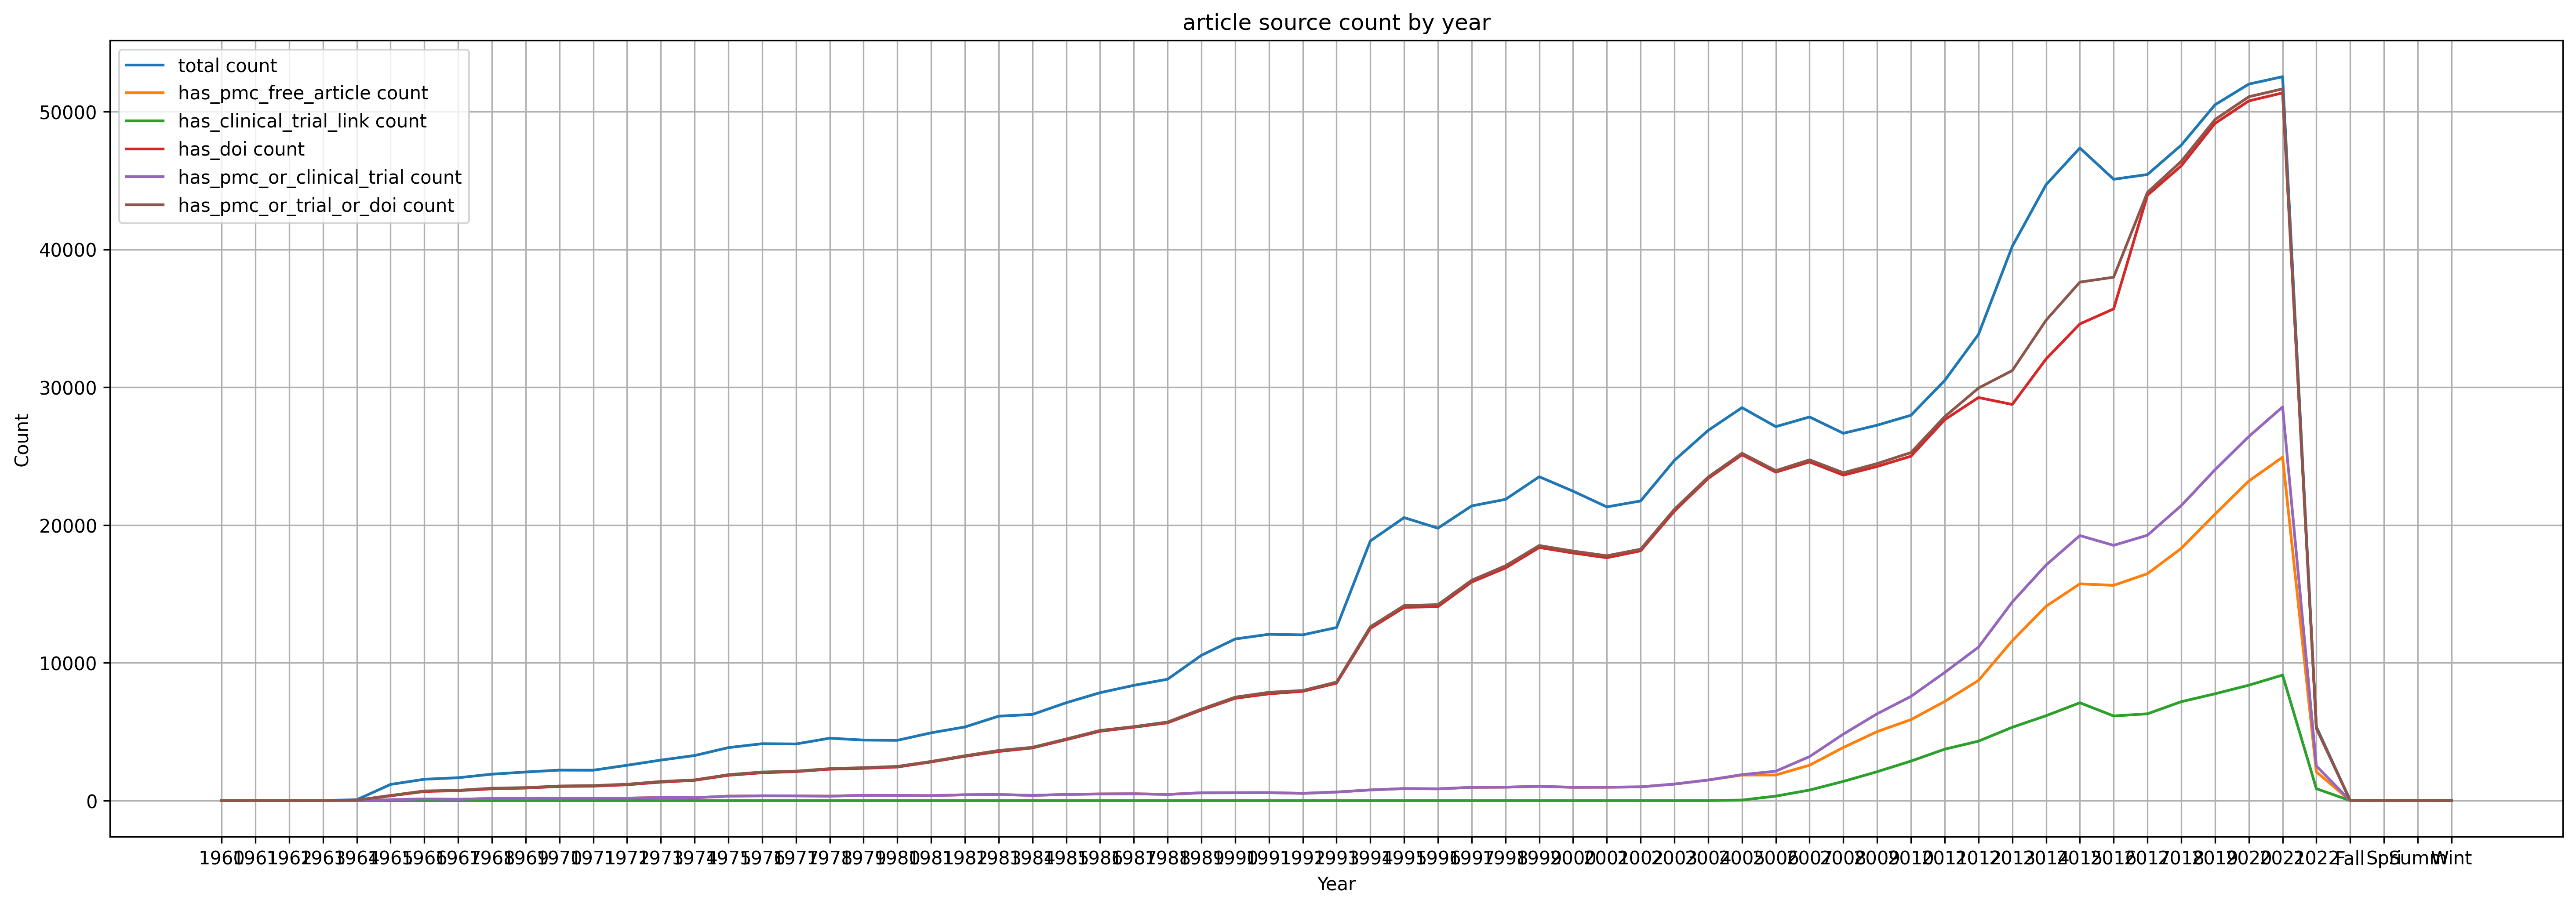

In [19]:

import matplotlib.pyplot as plt
result = data.groupby('journual_year').agg({
    'journual_year': ['count'], 
    'doi_is_not_empty':'sum', 
    'has_pmc_free_article': 'sum', 
    'has_clinical_trial_link': 'sum', 
    'has_pmc_or_trial':'sum', 
    'has_pmc_or_trial_or_doi': 'sum'})
plt.figure(dpi=300, figsize=(24, 8))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(result.index, result['journual_year']['count'], label='total count')
plt.plot(result.index, result['has_pmc_free_article']['sum'], label='has_pmc_free_article count')
plt.plot(result.index, result['has_clinical_trial_link']['sum'], label='has_clinical_trial_link count')
plt.plot(result.index, result['doi_is_not_empty']['sum'], label='has_doi count')
plt.plot(result.index, result['has_pmc_or_trial']['sum'], label='has_pmc_or_clinical_trial count')
plt.plot(result.index, result['has_pmc_or_trial_or_doi']['sum'], label='has_pmc_or_trial_or_doi count')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('article source count by year')
plt.grid(True)
plt.legend()

In [20]:
result.style.background_gradient(cmap ='BuGn')

,journual_year,doi_is_not_empty,has_pmc_free_article,has_clinical_trial_link,has_pmc_or_trial,has_pmc_or_trial_or_doi
,count,sum,sum,sum,sum,sum
journual_year,,,,,,
1960,1,1,0,0,0,1
1961,3,3,3,0,3,3
1962,1,1,1,0,1,1
1963,6,2,0,0,0,2
1964,59,30,0,0,0,30
1965,1172,344,59,0,59,371
1966,1547,660,118,0,118,696
1967,1658,719,92,0,92,743


In [26]:
data['clinical_trials_type']

0          [{'UI': 'D016430', 'text': 'Clinical Trial', '...
1          [{'UI': 'D016430', 'text': 'Clinical Trial', '...
2          [{'UI': 'D016430', 'text': 'Clinical Trial', '...
3          [{'UI': 'D016430', 'text': 'Clinical Trial', '...
4          [{'UI': 'D016430', 'text': 'Clinical Trial', '...
                                 ...                        
1064077    [{'UI': 'D016449', 'text': 'Randomized Control...
1064078    [{'UI': 'D016449', 'text': 'Randomized Control...
1064079    [{'UI': 'D016449', 'text': 'Randomized Control...
1064080    [{'UI': 'D016449', 'text': 'Randomized Control...
1064081    [{'UI': 'D016430', 'text': 'Clinical Trial', '...
Name: clinical_trials_type, Length: 1064082, dtype: object

In [56]:
import matplotlib.pyplot as plt

def array_to_str(array: list):
    values = [x.get('text', '') for x in array]
    values.sort()
    return ','.join(values)

data['clinical_trials_type_str'] = data['clinical_trials_type'].apply(lambda x: array_to_str(x))

result = data.groupby('clinical_trials_type_str').agg({
    'clinical_trials_type_str': ['count'], 
    'doi_is_not_empty':'sum', 
    'has_pmc_free_article': 'sum', 
    'has_clinical_trial_link': 'sum', 
    'has_pmc_or_trial':'sum', 
    'has_pmc_or_trial_or_doi': 'sum'})


In [117]:

result.to_csv('./publication_type_article_link.tsv', sep='\t')

